#**PLN - Universidad Nacional de Colombia**
## Asignatura Procesamiento de Lenguaje Natural - 2024
# Análisis No Supervisado de Texto

###Estudiante: David Esteban Casallas

---
---

# Análisis no supervisado de texto

Gran cantidad de los datos textuales que se generan no contienen etiquetas por lo que un modelo de clasisficación no es apropiado. Cuando no existen etiquetas en los textos lo que se desea es obtener conocimientos o patrones descriptivos del conjunto de documentos, es por eso que se  aplican modelos **descriptivos**, lo que se conoce como aprendizaje no supervisado.

Una de las más importantes aplicaciones es la identificación de temas o tópicos que son comunes a varios documentos a traves de algoritmos de **clustering** usando diversidad de representaciones de los documentos.

Como se mencionó anteriormente, una de las aproximaciones para encontrar tematicas son las técnicas de **clustering**. Por lo tanto, introduciremos algunos de los métodos clásicos de **clustering** aplicados a la identificación de tópicos: **K-means, affinity propagation y hierarchical clustering**.

Para realizar este taller se van a utilizar titulos de noticias de RCN.

In [3]:
# Se importan las librerías
import numpy as np
np.random.seed(0)
import pandas as pd
import json, nltk, re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("ggplot")
# Descargamos popular
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [6]:
import pandas as pd

df = pd.read_csv("/content/reviews_netflix.csv")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10062 entries, 0 to 10061
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   film_name         10062 non-null  object 
 1   film_publication  5786 non-null   float64
 2   film_duration     5786 non-null   object 
 3   film_country      5786 non-null   object 
 4   film_cast         5786 non-null   object 
 5   film_director     5786 non-null   object 
 6   fil_genre         5786 non-null   object 
 7   film_synopsis     5786 non-null   object 
 8   critic_name       5786 non-null   object 
 9   review_rate       5786 non-null   float64
 10  review_title      5786 non-null   object 
 11  review_date       5786 non-null   object 
 12  review_text       5786 non-null   object 
dtypes: float64(2), object(11)
memory usage: 1022.1+ KB


In [8]:
df.head()

film_name  film_publication  \
0                             Respira (Serie de TV)             2024.0   
1  Respira (Serie de TV) ,2024, 50 min. , España ...               NaN   
2                             Respira (Serie de TV)             2024.0   
3  Respira (Serie de TV) ,2024, 50 min. , España ...               NaN   
4                             Respira (Serie de TV)             2024.0   

  film_duration film_country                                     film_cast  \
0      50 min.       España    Carlos Montero- Marta Font- David Pinillos    
1           NaN          NaN                                           NaN   
2      50 min.       España    Carlos Montero- Marta Font- David Pinillos    
3           NaN          NaN                                           NaN   
4      50 min.       España    Carlos Montero- Marta Font- David Pinillos    

                                  film_director  \
0   Carlos Montero- Marta Font- David Pinillos    
1                                           NaN   
2   Carlos Montero- Marta Font- David Pinillos    
3                                           NaN   
4   Carlos Montero- Marta Font- David Pinillos    

                        fil_genre  \
0   Serie de TV- Drama- Medicina    
1                             NaN   
2   Serie de TV- Drama- Medicina    
3                             NaN   
4   Serie de TV- Drama- Medicina    

                                       film_synopsis         critic_name  \
0   Biel es uno de los residentes que lleva unos ...   Alfred Hitchcock    
1                                                NaN                 NaN   
2   Biel es uno de los residentes que lleva unos ...          LuisOrtiz    
3                                                NaN                 NaN   
4   Biel es uno de los residentes que lleva unos ...               nuri    

   review_rate                review_title                review_date  \
0          1.0                    Respira       30 de agosto de 2024    
1          NaN                         NaN                        NaN   
2          1.0   Imposible- no hay manera    4 de septiembre de 2024    
3          NaN                         NaN                        NaN   
4          1.0              Serie nefasta    4 de septiembre de 2024    

                                         review_text  
0   Como fan de las series españolas y de Najwa- ...  
1                                                NaN  
2   Nadie te obliga a ver nada que no quieras ver...  
3                                                NaN  
4   Está serie da vergüenza ajena. Una serie dond...

Sin embargo la base de datos original tiene reviews de usuarios por lo que debemos eliminar repeticiones de series y peliculas.

In [25]:
# Eliminar duplicados basados en la columna 'title'
df = df.drop_duplicates(subset=['film_name'], keep='first')

# Verificar el resultado
print(f"Número de filas después de eliminar duplicados: {len(df)}")

Número de filas después de eliminar duplicados: 656


Comenzaremos cargando el dataset y mostrando una descripción general:

Nos enfocaremos en tres campos dentro del dataset: "film_synopsis", "film_genre" y "film_name". Adicionalmente, se realizará una tarea de limpieza de datos, como existen valores inválidos (NAN), utilizamos la función `dropna` para eliminarlos.

In [26]:
# filtramos valores faltantes en las columnas de interes
df.dropna(axis=0, subset=["film_synopsis", "fil_genre", "film_name"], inplace=True)
# Reset the index after dropping rows to ensure it's a sequence of integers starting from 0
df.reset_index(drop=True, inplace=True)
df['film_synopsis'].count()

656

In [27]:
for i in range(5):
    print(f"{' ':8}Ejemplo {i+1}")
    # Use .iloc to access rows by their position in the DataFrame
    print(f"* Titulo: {df['film_name'].iloc[i]}\n")
    print(f"* Synopsis: {df['film_synopsis'].iloc[i]}\n")
    print(f"* Genero: {df['fil_genre'].iloc[i]}\n")

        Ejemplo 1
* Titulo: Respira (Serie de TV) 

* Synopsis:  Biel es uno de los residentes que lleva unos meses dejándose la piel en un hospital público. Cientos de guardias- miles de horas- que apenas le dejan tiempo para su vida- todo con tal de convertirse en el mejor doctor. Lo que no se imagina es que en el hospital va a estallar una huelga total- sin servicios mínimos. Los sanitarios se ven obligados a ello para tratar de concienciar a la población sobre su trabajo esencial y para protestar por todos los recortes intolerables que está sufriendo la sanidad pública. Pero Biel y los demás residentes no saben si secundar esa huelga que puede tener consecuencias fatales para los pacientes. Y desde ese conflicto iremos conociendo a unos y otros en su día a día. ¿Quiénes son esos chicos jóvenes que se desviven en el hospital asumiendo una responsabilidad excesiva- y quiénes son esos adultos dispuestos a perderlo todo con tal de luchar por lo que creen? 

* Genero:  Serie de TV- Dram

Ahora, extraeremos los tres campos del dataframe. Adicionalmente, los géneros se convierten de formato json a una lista de strings en python:

In [28]:
# Extraemos los resúmenes y los guardamos en corpus
corpus = df.film_synopsis.tolist()

# Extraemos los géneros y los guardamos en genres
genres = [[genre.strip() for genre in fil_genre.split('-')] for fil_genre in df.fil_genre.tolist()]

# Extraemos los títulos y los guardamos en titles
titles = df.film_name.tolist()

Veamos cómo queda el dataset:

In [29]:
# Para revisar, se imprimen los titulos en t, géneros en g y resumen en c (del resumen solo se imprimen 40 caracteres)
for c,g,t in zip(corpus[:3], genres[:3], titles[:3]):
    print(f"* Título: {t}, géneros: {g}, resumen: {c[:30]}...")

* Título: Respira (Serie de TV) , géneros: ['Serie de TV', 'Drama', 'Medicina'], resumen:  Biel es uno de los residentes...
* Título: La liberación , géneros: ['Terror', 'Intriga', 'Sobrenatural', 'Casas encantadas', 'Basado en hechos reales'], resumen:  Una familia que vive en una c...
* Título: Kaos (Serie de TV) , géneros: ['Serie de TV', 'Comedia', 'Fantástico', 'Mitología'], resumen:  Serie de TV (2024-). 1 tempor...


## Preprocesamiento



Antes que nada si vemos en el paso anterior tenemos titulos saturados de información adicional, en particular textos en parentesis por lo que vamos a remover esta información obsoleta.

In [30]:
import re

# Función para eliminar el contenido entre paréntesis
def eliminar_parentesis(titulo):
    return re.sub(r'\([^)]*\)', '', titulo).strip()

# Aplicar la función a la lista 'titles'
titles = [eliminar_parentesis(titulo) for titulo in titles]

# Verificar el resultado
print(titles[:5])  # Imprime los primeros 5 títulos para verificar

['Respira', 'La liberación', 'Kaos', 'Terminator Zero', 'Presidente por accidente']


Utilizaremos las mismas técnicas de preprocesamiento que hemos venido aplicando a lo largo del curso. Más específicamente, convertiremos el corpus (resúmenes) a minúsculas, separaremos los signos de puntuación y eliminaremos stopwords y caracteres especiales. En este caso también se eliminaron palabras que estorban en los textos como "filaffinity", "temporada", "capitulos", entre otras.

In [31]:
corpus[:5]

[' Biel es uno de los residentes que lleva unos meses dejándose la piel en un hospital público. Cientos de guardias- miles de horas- que apenas le dejan tiempo para su vida- todo con tal de convertirse en el mejor doctor. Lo que no se imagina es que en el hospital va a estallar una huelga total- sin servicios mínimos. Los sanitarios se ven obligados a ello para tratar de concienciar a la población sobre su trabajo esencial y para protestar por todos los recortes intolerables que está sufriendo la sanidad pública. Pero Biel y los demás residentes no saben si secundar esa huelga que puede tener consecuencias fatales para los pacientes. Y desde ese conflicto iremos conociendo a unos y otros en su día a día. ¿Quiénes son esos chicos jóvenes que se desviven en el hospital asumiendo una responsabilidad excesiva- y quiénes son esos adultos dispuestos a perderlo todo con tal de luchar por lo que creen? ',
 ' Una familia que vive en una casa en Indiana descubre sucesos extraños y demoníacos que

In [39]:
import re
import nltk
from nltk.corpus import stopwords

# Descargar stopwords en español (si no las tienes ya)
nltk.download('stopwords')

# Función para preprocesar los textos en español
def preprocessing(doc):
    wpt = nltk.WordPunctTokenizer()
    stop_words = set(stopwords.words('spanish'))  # Stopwords en español

    # Añadir palabras personalizadas a eliminar
    custom_stopwords = {"serie", "temporada", "episodios"}
    stop_words.update(custom_stopwords)

    # Eliminar información obsoleta al inicio y al final
    doc = re.sub(r'^Serie de TV\s*\(.*?\)\.\s*\d+\s*temporada\.\s*\d+\s*episodios\.', '', doc)  # Eliminar inicio
    doc = re.sub(r'\(FILMAFFINITY\)$', '', doc)  # Eliminar final

    # Eliminar la palabra "filmaffinity" (en cualquier parte del texto)
    doc = re.sub(r'\bfilmaffinity\b', '', doc, flags=re.IGNORECASE)

    # Eliminar caracteres especiales (excepto letras y espacios)
    doc = re.sub(r'[^a-zA-ZáéíóúñÁÉÍÓÚÑ\s]', '', doc)

    # Convertir a minúsculas
    doc = doc.lower()

    # Tokenizar el texto
    tokens = wpt.tokenize(doc)

    # Eliminar stopwords y palabras vacías
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]

    # Retornar una versión filtrada del texto
    return ' '.join(tokens)

# Aplicar la función a la lista de resúmenes (corpus)
norm_corpus = list(map(preprocessing, corpus))

# Verificar el resultado
print(norm_corpus[0])
print(norm_corpus[1])
print(norm_corpus[2])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


biel residentes lleva meses dejándose piel hospital público cientos guardias miles horas apenas dejan tiempo vida tal convertirse mejor doctor imagina hospital estallar huelga total servicios mínimos sanitarios ven obligados ello tratar concienciar población trabajo esencial protestar recortes intolerables sufriendo sanidad pública biel demás residentes saben secundar huelga puede tener consecuencias fatales pacientes conflicto iremos conociendo día día quiénes chicos jóvenes desviven hospital asumiendo responsabilidad excesiva quiénes adultos dispuestos perderlo tal luchar creen
familia vive casa indiana descubre sucesos extraños demoníacos convencen comunidad casa portal infierno
nueva versión contemporánea mitología griega mientras monte olimpo reina discordia todopoderoso zeus sucumbe paranoia tres mortales destinados cambiar futuro humanidad


## Representación del texto

Para representar cada documento utilizaremos **Word2Vec**:

1. Este modelo se entrenará utilizando todo el corpus normalizado (resúmenes) de películas.
2. Además, la representación de un documento será el promedio de la representación de cada uno de sus términos.
3. Con el propósito de visualizar los resultados, utilizaremos t-SNE (técnica para reducción de dimensionalidad) para obtener vectores bidimensionales $\vec{x_j}\in \mathbb{R}^2$.

***Nota: una dimensión vectorial tan pequeña no es muy recomendada, aquí lo usamos sólo para visualizar el funcionamiento de métodos no supervisados***

In [40]:
# Se construye una representación word2vec de 100 dimensiones,
# con una ventana de contexto de 5, usando 200 iteraciones en el modelo de aprendizaje

from gensim.models import word2vec

# Parámetros del modelo w2v
feature_size = 100
window_context = 5
min_word_count = 1
sample = 1e-3
# Definimos un tokenizador
wpt = nltk.WordPunctTokenizer()
# Tokenizamos el corpus
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]
# Entrenamos el modelo w2v con el corpus tokenizado
w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size=100,                              window=window_context, min_count=min_word_count,
                              sample=sample)

Recordemos que Word2Vec representa cada palabra como un vector. Para obtener una representación estructurada de un documento debemos calcular un vector promedio:

In [41]:
# Se construye la representación de los documentos como el promedio de la
# representación de cada una de sus palabras.
def w2v_repr(corpus):
    w2v_representations = []
    tokenized_corpus = [wpt.tokenize(document) for document in corpus]
    for sentence in tokenized_corpus:
        try:
            w2v_representations.append(w2v_model.wv[sentence].mean(axis=0))
        except:
            w2v_representations.append(np.zeros(shape=(feature_size,)))
    return np.array(w2v_representations)

X_w2v = w2v_repr(norm_corpus)

In [43]:
w2v_model.wv[["meses", "casa"]]#.mean(axis=0)

array([[-7.95865245e-03, -5.21577836e-04,  9.29164980e-03,
         3.09029501e-03,  1.72413443e-03, -1.55147898e-03,
        -2.97582708e-03, -7.09953671e-03,  8.37214664e-03,
         5.02513954e-03, -6.92792190e-03, -7.56208273e-03,
        -2.23920029e-03, -3.68689373e-03,  4.78631910e-03,
        -3.71898594e-03, -5.75780869e-03, -3.98363406e-03,
        -4.14913775e-05,  7.91693758e-03, -1.18056705e-04,
         2.77862186e-04,  4.68292926e-03,  1.45561784e-03,
        -7.31109083e-03, -9.03630070e-03, -4.44883481e-03,
         7.88532663e-03, -5.21704974e-03,  9.70454235e-03,
         4.14254563e-03, -1.23096711e-03, -4.66006203e-03,
        -1.25662031e-04, -8.01184960e-03, -3.81599413e-03,
        -3.05139925e-03,  3.40187992e-03, -5.33333281e-03,
        -8.60410742e-03,  8.01085401e-03, -1.22899670e-04,
        -1.04510190e-03,  3.55895679e-03, -5.40588005e-03,
         1.80565892e-03,  6.25344459e-03, -8.67895689e-03,
         6.24132296e-03,  5.88183105e-03, -6.74005877e-0

In [44]:
print(X_w2v.shape)
X_w2v[0]

(656, 100)


array([ 1.2410410e-04,  3.1709598e-04, -3.1965991e-04, -1.8404254e-03,
       -1.0586284e-04, -1.2127080e-03,  1.0445464e-03,  1.1727574e-03,
       -6.8861968e-04,  1.2902814e-04, -1.3919433e-03, -7.3351833e-04,
        1.3477496e-04, -1.3956582e-03,  3.9289441e-04, -8.3321281e-04,
        9.3872496e-04, -1.1788056e-03,  9.5168897e-04, -3.1597316e-04,
       -3.9889253e-04,  4.7068635e-04,  1.0555533e-03, -8.6245209e-04,
        8.4640383e-04, -4.1740289e-04, -1.2926259e-03, -4.3567934e-04,
        2.9914847e-04,  3.0092825e-04,  1.9603071e-04, -4.2715290e-04,
        6.1273715e-04, -2.5479251e-04, -1.6878834e-03,  5.0684444e-05,
       -6.2204007e-04, -6.4891722e-04,  7.7904720e-04, -2.0708526e-03,
       -7.1330921e-04, -4.0541872e-04,  2.1918077e-04,  5.7119585e-04,
        1.2153222e-03, -1.2336568e-03, -1.3298910e-03,  4.1456771e-04,
        6.3292602e-05,  4.6096795e-04, -6.6720182e-05, -1.7691025e-04,
       -2.3149702e-04, -1.2889103e-03, -2.6020821e-04,  1.3988969e-03,
      

Ahora, utilizaremos t-SNE para visualizar las representaciones de Word2Vec:

In [45]:
# se aplica técnica de reducción de dimensionalidad para visualizar en dos dimensiones
# solo con fines de visualización

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=2, verbose=1)
T = tsne.fit_transform(X_w2v)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 656 samples in 0.001s...
[t-SNE] Computed neighbors for 656 samples in 0.106s...
[t-SNE] Computed conditional probabilities for sample 656 / 656
[t-SNE] Mean sigma: 0.001413
[t-SNE] KL divergence after 250 iterations with early exaggeration: 110.250839
[t-SNE] KL divergence after 1000 iterations: 2.727056


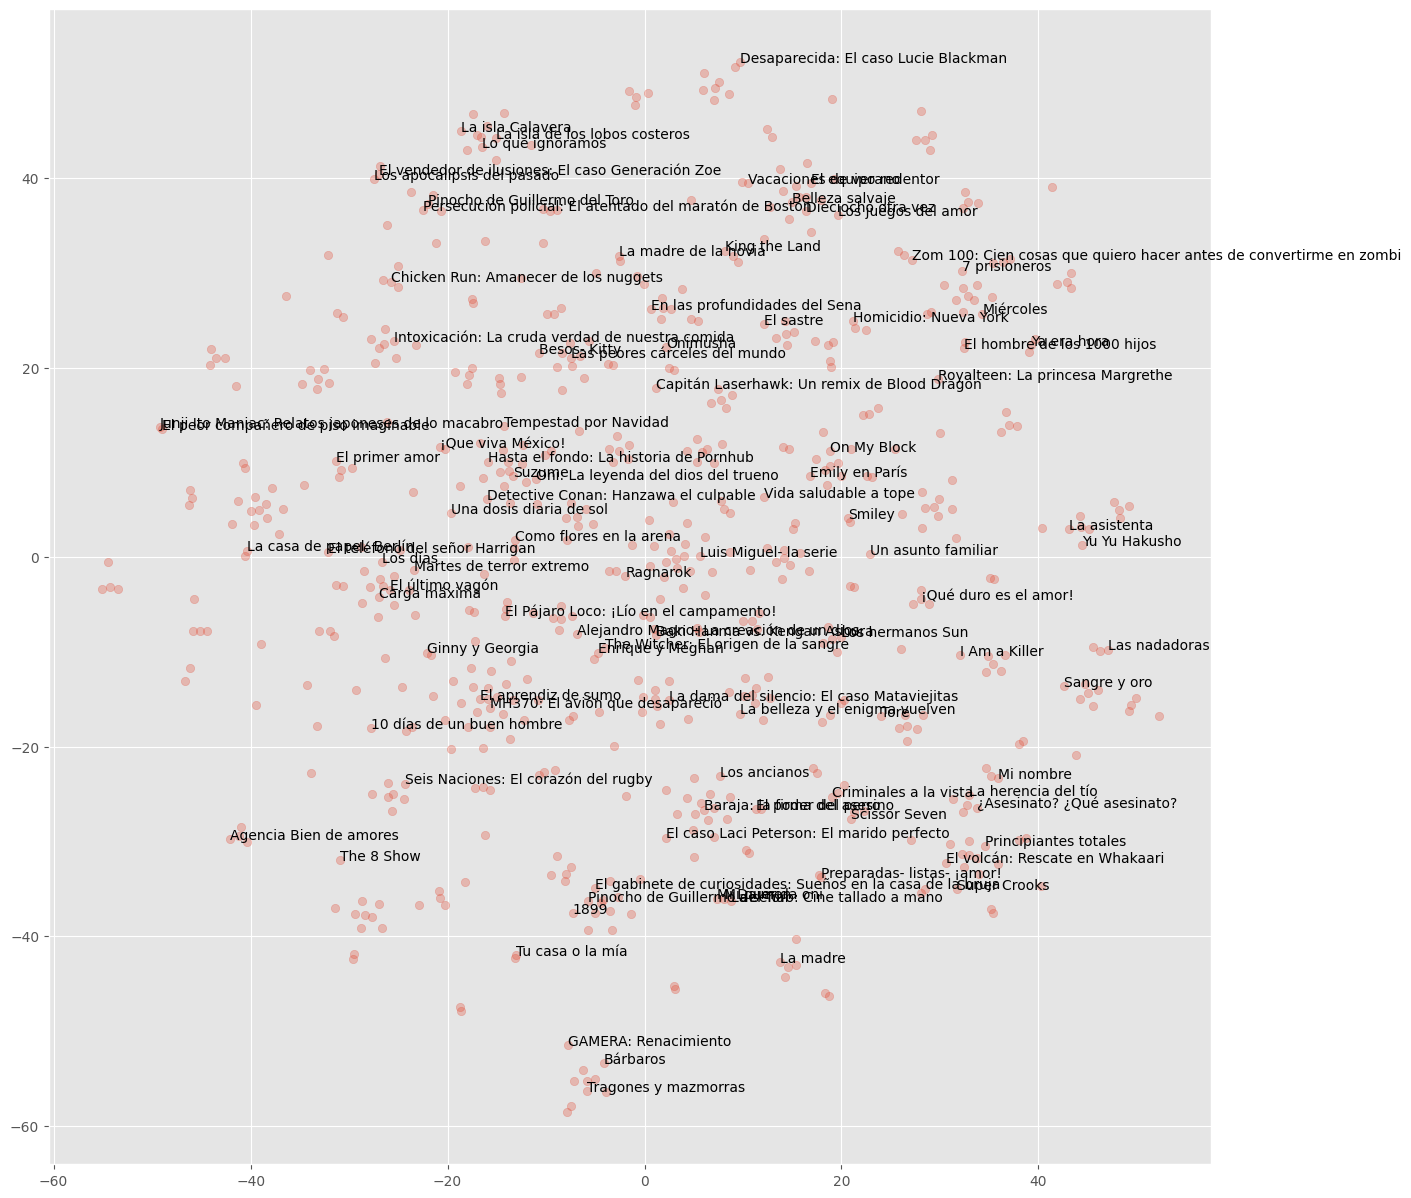

In [46]:
# Visualizamos la representación de las películas
plt.figure(figsize=(15, 15))
# Seleccionamos el número de documentos del que se mostrará el título
n_docs = 100
# Generamos una secuencia de enteros correspondiente a los índices de los documentos
idx = np.arange(len(corpus))
# Seleccionamos de forma aleatoria n_docs documentos
valid_idx = np.random.choice(idx, replace=False, size=n_docs)
# Visualizamos todas las representaciones
plt.scatter(T[:, 0], T[:, 1], alpha=0.3)
# Seleccionamos los títulos que se van a visualizar
viz_titles = [titles[i] for i in valid_idx]
# Asignamos los títulos al punto correspondiente
for label, x, y in zip(viz_titles, T[valid_idx, 0], T[valid_idx, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

# Modelamiento: **Agrupación**



## K-means

Se trata del método más básico de clustering y consiste en estimar de forma automática grupos dentro de la representación de los datos, de tal forma que los puntos u objetos más parecidos queden en el mismo grupo y los grupos entre sí sean lo más diferentes posible.

En la siguiente figura se muestra como el algoritmo encuentra los grupos después de varias iteraciones:

![k-means](https://raw.githubusercontent.com/larajuse/share/master/kmeans.gif)

En k-means clustering, tenemos que especificar el número de grupos en los que queremos que se agrupen los datos.

1. El algoritmo asigna aleatoriamente cada observación a un grupo y encuentra el centroide de cada grupo.

2. Luego, el algoritmo itera a través de dos pasos:

    * Reasigna puntos de datos al grupo cuyo centroide es el más cercano.
    * Calcula el nuevo centroide de cada grupo.
  
  Estos dos pasos se repiten hasta que la variación dentro del clúster no se pueda reducir más. La variación dentro del grupo se calcula como la suma de la distancia euclidiana entre los puntos de datos y sus respectivos centroides del grupo.

Veamos un ejemplo con una versión muy simple de K-means:

Text(0, 0.5, '$x_2$')

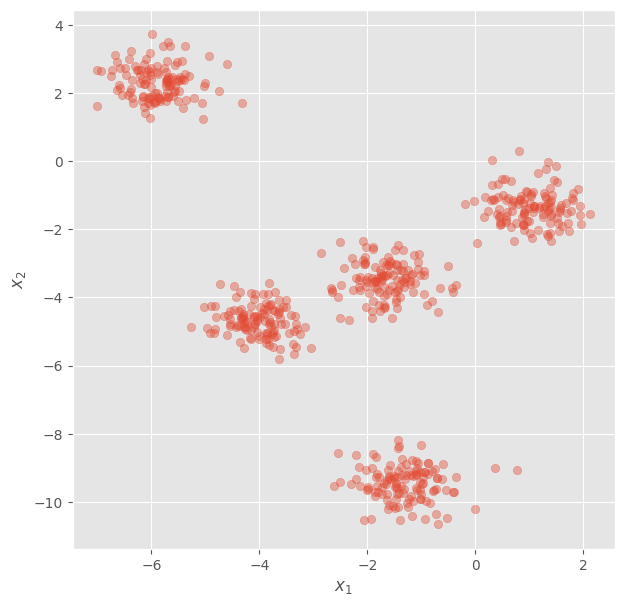

In [47]:
from sklearn.datasets import make_blobs
np.random.seed(2)

# Creamos un dataset sintético
X,_ = make_blobs(n_samples=600, centers=5, cluster_std=0.5)
plt.figure(figsize=(7, 7))
plt.scatter(X[:,0], X[:,1], alpha=0.4)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

Definimos una función que implementa el algortmo de K-Means (esta implementación es sólo con fines demostrativos, no está optimizada ni  paralelizada)

In [48]:
from sklearn.metrics.pairwise import euclidean_distances

# Definimos una función para entrenar un modelo K-Means
def simple_kmeans(X, k, iter=100):
    init_clus = np.random.choice(np.arange(X.shape[0]), replace=False, size=k)
    clusters = X[init_clus]
    preds = np.argmin(euclidean_distances(X, clusters), axis=1)
    all_clusters = [clusters.copy()]
    all_preds = [preds]
    for i in range(iter):
        for clus in range(k):
            clusters[clus] = X[preds==clus].mean(axis=0)
            all_clusters.append(clusters.copy())
            preds = np.argmin(euclidean_distances(X, clusters), axis=1)
            all_preds.append(preds.copy())
    return all_clusters, all_preds

all_clusters, all_preds = simple_kmeans(X, 5)

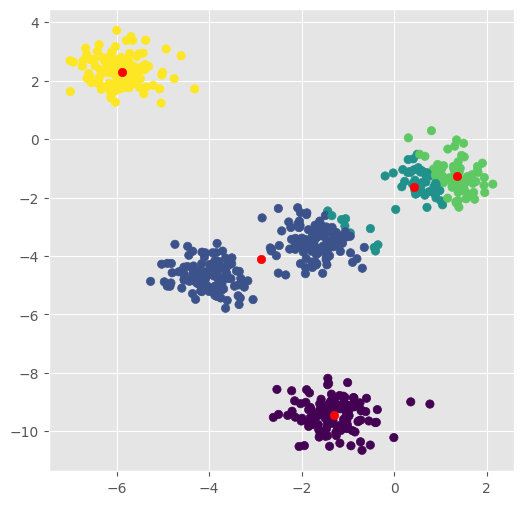

In [50]:
# Iteración 0. Se realiza la inicialización aleatoriamente, para el ejemplo son 5 puntos,
# y los demas puntos se asignan al cluster más cercano.

iteration=15 #@param {type:"slider", min:0, max:40, step:1}
plt.figure(figsize=(6, 6))
plt.scatter(X[:,0], X[:,1], c=all_preds[iteration])
plt.scatter(all_clusters[iteration][:, 0], all_clusters[iteration][:,1],c="r")


Ahora veamos los grupos en la implementación de K-means en sklearn:

In [51]:
# Importamos el modelo de K-means
from sklearn.cluster import KMeans

# Definimos el modelo con 5 clusters
clf = KMeans(n_clusters=5)
# Entrenamos el modelo
clf.fit(X)
# Obtenemos el cluster asignado a cada uno de los puntos
clusters_pred = clf.predict(X)

Text(0, 0.5, '$x_2$')

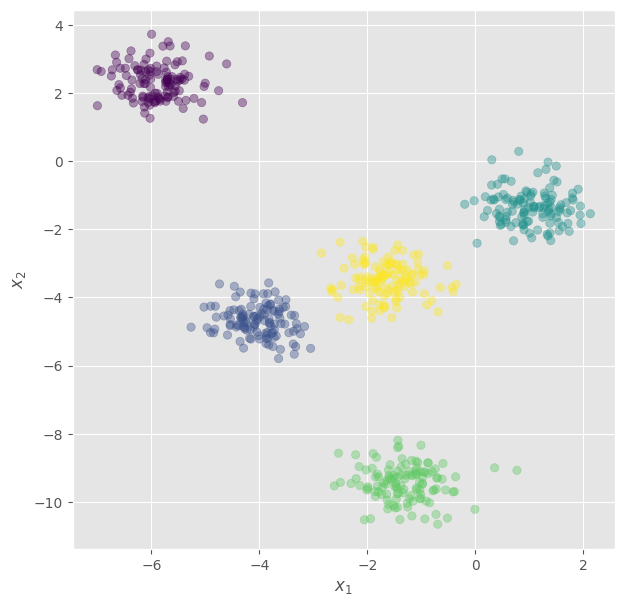

In [52]:
# Mostramos los resultados
plt.figure(figsize=(7, 7))
plt.scatter(X[:,0], X[:,1], c=clusters_pred, alpha=0.4)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

Podemos observar que K-means permite identificar zonas de alta densidad en el espacio de la representación. Ahora, retomaremos el caso del dataset de películas para ver qué patrones se identifican con este método. En este caso se desea **agrupar las películas**, es decir, que en cada grupo deben quedar las películas más parecidas, y los grupos entre sí deben estar lo más alejados posible. El agrupar documentos por contenido se conoce como: **Document clustering**

In [53]:
# comenzaremos encontrando 4 clusters.
clf = KMeans(n_clusters=5)
clf.fit(X_w2v)

KMeans(n_clusters=5)

Ahora visualizamos los clusters asignados en dos dimensiones, con la representación obtenida de t-SNE:

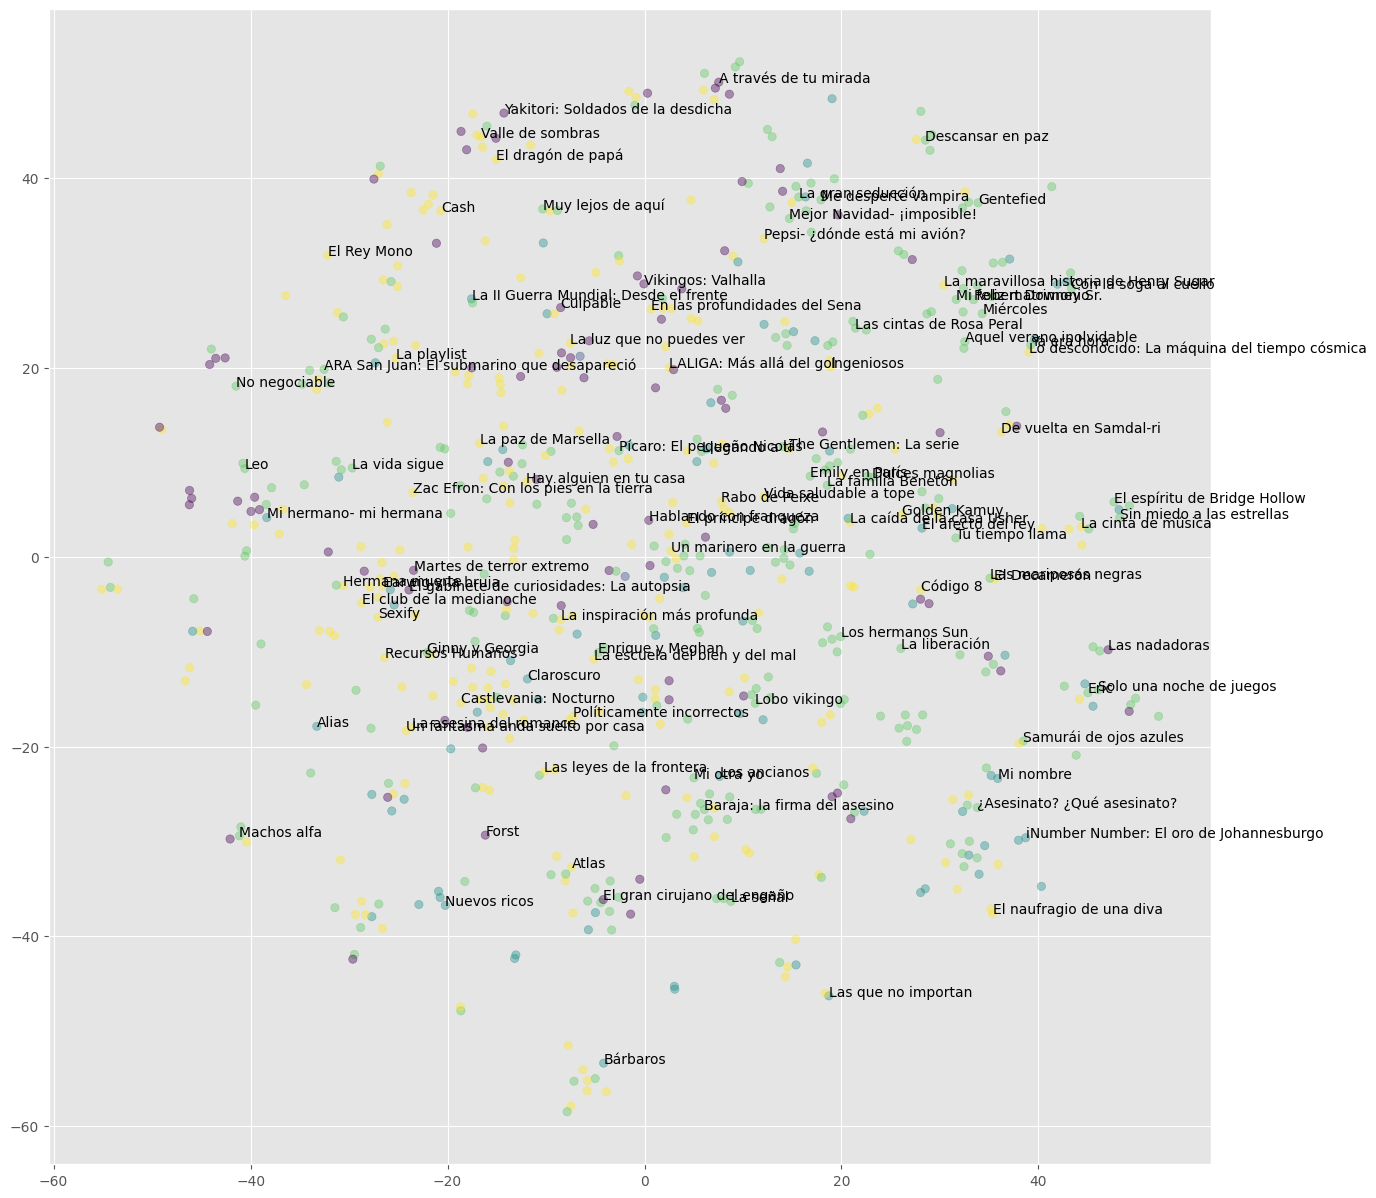

In [54]:
# Obtenemos el cluster asignado a cada documento
clusters = clf.predict(X_w2v)
# Visualizamos las predicciones en el espacio de t-SNE
plt.figure(figsize=(15, 15))
# Especificamos el número de documentos del que se mostrará el título
n_docs = 100
# Generamos una secuencia de enteros correspondiente a los índices de los documentos
idx = np.arange(len(corpus))
# Seleccionamos aleatoriamente 50 documentos
valid_idx = np.random.choice(idx, replace=False, size=n_docs)
# Mostramos las representaciones y asignamos el color a las predicciones de K-means
plt.scatter(T[:, 0], T[:, 1], c=clusters, alpha=0.4)
# Seleccionamos los títulos que se van a visualizar
viz_titles = [titles[i] for i in valid_idx]
# Mostramos los títulos asignados a cada punto
for label, x, y in zip(viz_titles, T[valid_idx, 0], T[valid_idx, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

Veamos algunos ejemplos de películas en cada uno de los clusters:

In [55]:
# Generamos una secuencia de enteros correspondiente a los índices de los documentos
idx = np.arange(X_w2v.shape[0])

for clus in range(4):
    # Seleccionamos aleatoriamente los índices de 10 películas dentro del cluster
    example_idxs = np.random.choice(idx[clusters==clus], 10)
    # Seleccionamos los títulos correspondientes
    examples = [titles[i] for i in example_idxs]
    print("Ejemplos aleatorios dentro del cluster {}".format(clus))
    print(examples)

Ejemplos aleatorios dentro del cluster 0
['Hitler y los nazis: La maldad a juicio', '¡Qué duro es el amor!', 'Rumbo al infierno', '¡Qué duro es el amor!', 'Hablando con franqueza', 'Studio 666', 'King the Land', 'Los entresijos de la FIFA', 'La bala perdida 2', '¡Qué duro es el amor!']
Ejemplos aleatorios dentro del cluster 1
['Family Business', 'Family Business', 'Ragnarok', 'Ragnarok', 'Ragnarok', 'Family Business', 'Ragnarok', 'Ragnarok', 'Ragnarok', 'Ragnarok']
Ejemplos aleatorios dentro del cluster 2
['La belleza y el enigma vuelven', 'On My Block', 'Todos quieren salvarse', 'El salario del miedo', 'La reina de las lágrimas', 'Wham!', 'Baki Hanma vs. Kengan Ashura', 'El extraño', 'Testamento: La historia de Moisés', 'La vida en nuestro planeta']
Ejemplos aleatorios dentro del cluster 3
['Criptoestafas', 'Mi dulce niña', 'El primer amor', 'Mi otra yo', 'Chico come universo', 'Sangre de Zeus', 'Los hermanos Sun', 'Ginny y Georgia', 'Preparadas- listas- ¡amor!', '¿Qué hizo Jennifer?'

Ahora, podemos visualizar una nube de palabras con los términos más relevantes de cada cluster con el fin de interpretar qué relaciones semánticas está aprendiendo K-means:

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


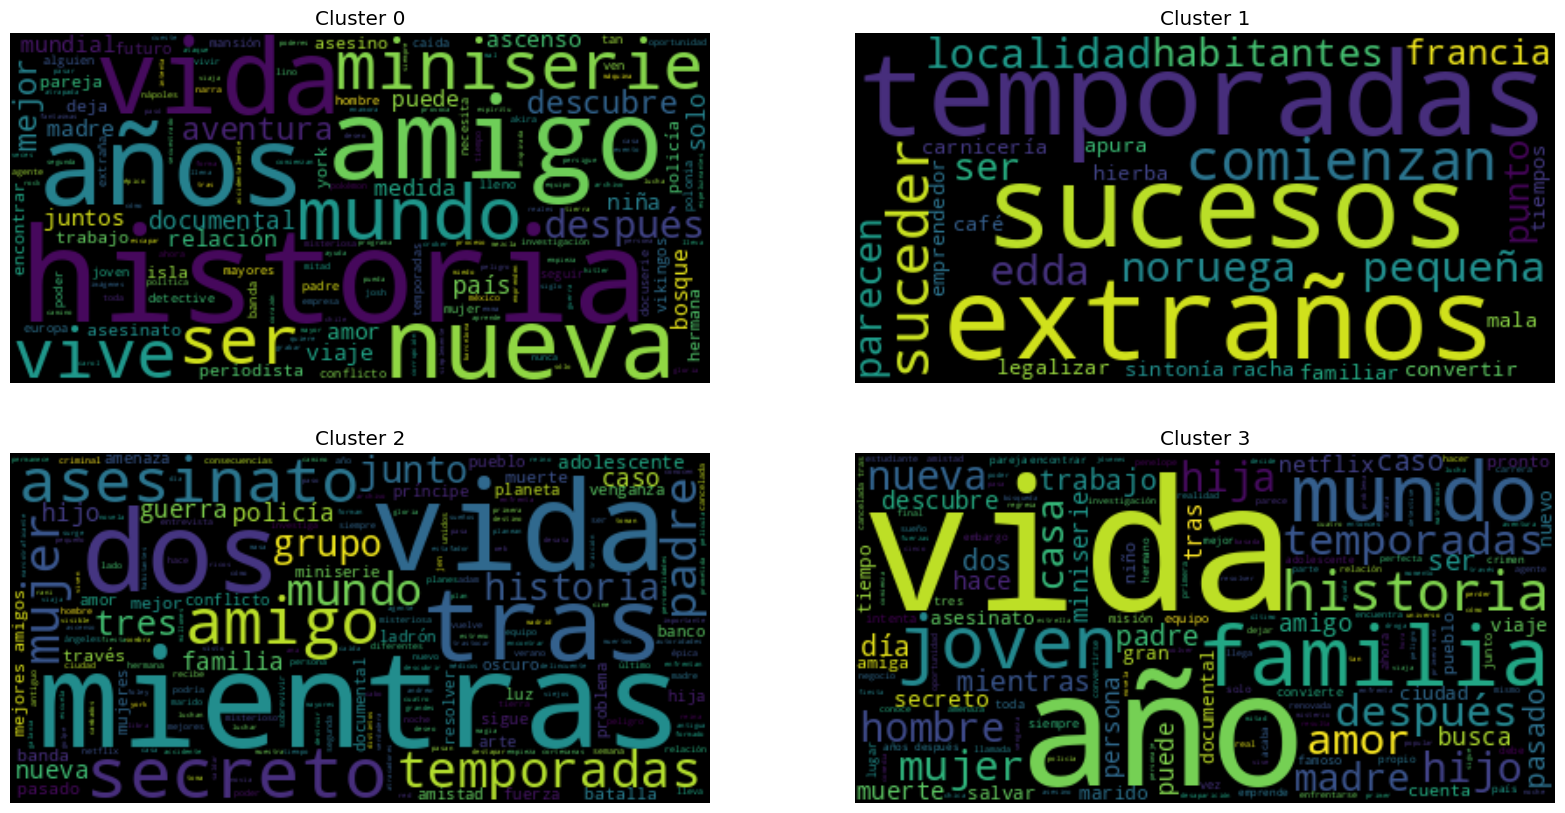

In [56]:
# Nube de palabras
from wordcloud import WordCloud
# Descargamos las stopwords de NLTK
nltk.download("stopwords")
# Importamos las stopwords
from nltk.corpus import stopwords
# Importamos la función reduce
from functools import reduce

# Generamos una secuencia de enteros correspondiente a los índices de los documentos
idx = np.arange(len(norm_corpus))
plt.figure(figsize=(20,10))
for clus in range(4):
    # Concatenamos las palabras de todos los documentos en cada cluster en un único string
    # (el reduce puede ser reemplazado por " ".join como vimos en ejemplos de clases anteriores)
    all_words = reduce(lambda a, b:a+" "+b, [norm_corpus[i] for i in idx[clusters==clus]])
    # Creamos la nube de palabras
    im = WordCloud(stopwords=stopwords.words("english")).generate(all_words)
    # Visualizamos la nube de palabras
    plt.subplot(221+clus)
    plt.imshow(im, interpolation="bilinear")
    plt.axis("off")
    plt.title("Cluster {}".format(clus))

Finalmente, veamos la proporción original de géneros dentro de cada uno de los clusters encontrados. Es decir vamos a utilizar la clasificación original que tiene la película y comparar con nuestros grupos:

¿Qué podemos concluir?

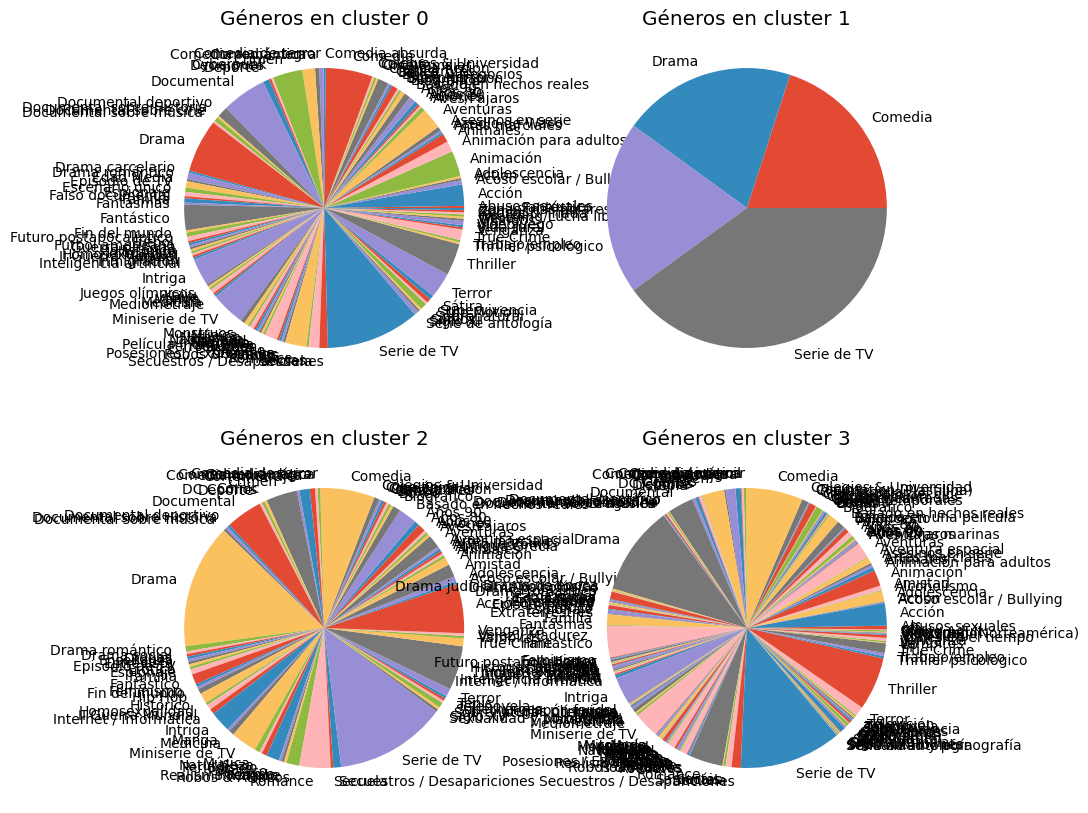

In [57]:
plt.figure(figsize=(10,10))
for clus in range(4):
    plt.subplot(221+clus)
    # Seleccionamos los índices correspondientes a cada cluster
    example_idxs = idx[clusters==clus]
    # Seleccionamos y concatenamos los géneros de todas las películas en cada cluster
    exam_genres = reduce(lambda a, b:a+b, [genres[i] for i in example_idxs])
    # Obtenemos un conteo de los géneros por cluster
    names, counts = np.unique(exam_genres, return_counts=True)
    # Normalizamos los conteos
    counts = counts/counts.sum()
    # Visualizamos un diagrama de pie
    plt.pie(counts, labels=names)
    plt.title("Géneros en cluster {}".format(clus))

Una de las principales desventajas de K-means es que se debe escoger un número de clusters $K$. Generalmente, se selecciona utilizando información previa o por medio de un análisis exploratorio.

**Método del codo (elbow)**: exploraremos cuáles son los efectos de la variación de $K$ sobre la pérdida de K-means $\mathcal{L}$.



In [58]:
# Generamos un arreglo con el número de clusters que se va a explorar
ks = np.arange(1, 25)
# Creamos una lista con la pérdida del modelo de K-means entrenado con el distinto número de clusters.
scores = [-KMeans(n_clusters=k).fit(X_w2v).score(X_w2v) for k in ks]

Veamos una curva de la pérdida contra el número de clusters:

Text(0, 0.5, '$\\mathcal{L}$')

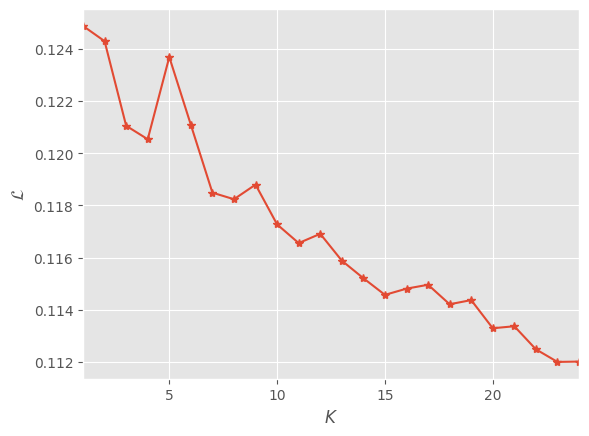

In [59]:
plt.plot(ks,scores,"*-")
plt.xlim([ks.min(), ks.max()])
plt.xlabel("$K$")
plt.ylabel("$\mathcal{L}$")

Esta gráfica provee información importante para la selección del número de clusters. Se trata de un *trade-off* entre un modelo más pequeño (menor número de clusters) y una pérdida menor. Lo ideal, es aprovechar el comportamiento exponencial de esta curva y seleccionar un número de clusters que reduzca de forma considerable la pérdida sin la necesidad de tener un modelo muy grande.

## Affinity propagation

Una alternativa a K-means es affinity propagation (AP). Se trata de un método basado en grafos que calcula de forma automática el número de clusters $K$ en un dataset.

Una forma intuitiva de entender AP es suponiendo que los datos son un grafo, donde cada punto está enviando mensajes a todos los demás de forma continúa. El objetivo de estos mensajes es determinar la voluntad o complacencia de un conjunto de puntos representativos conocidos como ejemplares (análogo a los clusters en K-means).

![affinity_propagation](https://www.ritchievink.com/img/post-14-affinity_propagation/preference_median.gif)


Cada punto busca determinar de forma colectiva los puntos que son representativos para cada uno por medio de dos matrices:

* Una matriz de responsabilidad $\mathbf{R}$, donde cada elemento $r_{i,k}$ representa qué tan adecuado es un punto $k$ para ser ejemplar de un punto $i$.
* Una matriz de disponibilidad $\mathbf{A}$, donde cada elemento $a_{i,k}$ representa qué tan apropiado sería para un punto $i$ escoger a un punto $k$ como su ejemplar.

Estas dos matríces representan un grafo donde cada punto está conectado con todos los otros puntos, por ejemplo:

![ap_graph](https://www.ritchievink.com/img/post-14-affinity_propagation/graph.svg)

En AP las matrices de responsabilidad y disponibilidad se modifican en base a una medida de similitud entre los datos (por ejemplo, la distancia euclidiana produce resultados similares a K-means), dicha similitud se codifica como una matríz $\mathbf{S}$ donde cada elemento $s_{i,k}$ representa la similitud entre un punto $i$ y otro punto $k$.

En la práctica, affinity propagation usa los siguientes parámetros:

* *affinity*: define la medida de similitud, en sklearn se puede usar "euclidian" o "precomputed". En el segundo caso se debe calcular una matríz de similitud con la distancia deseada.
* *damping*: se trata de un parámetro usado en la implementación de affinity propagation que es análogo a una taza de aprendizaje (los autores del método sugieren valores entre 0.5 y 1). Un valor cercano a 0.5 genera un mayor número de clusters mientras un valor cercano a 1 genera un menor número de clusters.
* *max_iter*: como se trata de un método iterativo, requiere un número máximo de iteraciones.

Veamos un ejemplo de la aplicación de Affinity Propagation con el mismo dataset sintético que utilizamos con K-means:

In [60]:
# Importamos el modelo de Affinity Propagation
from sklearn.cluster import AffinityPropagation

# Instanciamos el modelo
clf = AffinityPropagation(damping=0.9)
# Entrenamos el modelo con el dataset sintético
clf.fit(X)
# Obtenemos las predicciones de cada punto
clusters_pred = clf.predict(X)

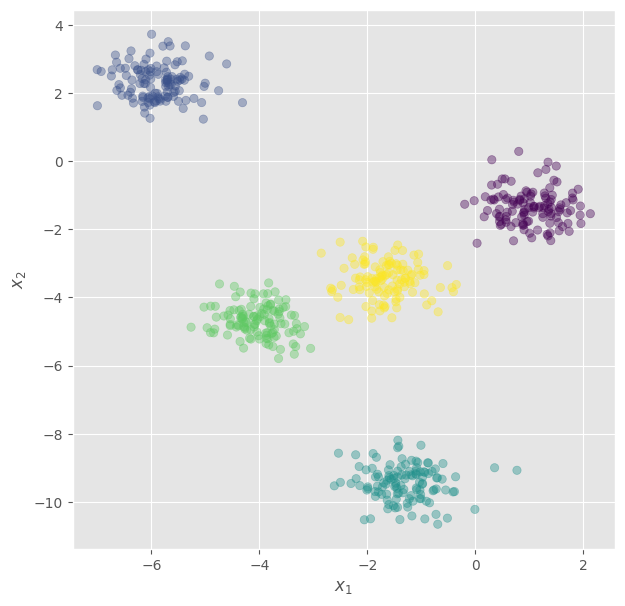

In [61]:
# Visualizamos los grupos
plt.figure(figsize=(7,7))
plt.scatter(X[:,0], X[:,1], c=clusters_pred, alpha=0.4)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

Podemos ver que el método encontró automáticamente que deben haber 5 puntos ejemplares. Ahora, retomemos el ejemplo con el dataset de películas para ver cuántos clusters estima AP.

In [85]:
# Definimos el modelo
clf = AffinityPropagation(damping=0.98, max_iter=1000)
# Entrenamos el modelo con las representaciones de w2v
clf.fit(X_w2v)
# Obtenemos las predicciones
clusters = clf.predict(X_w2v)

Ahora, veamos cómo se ven los grupos en el espacio de t-SNE

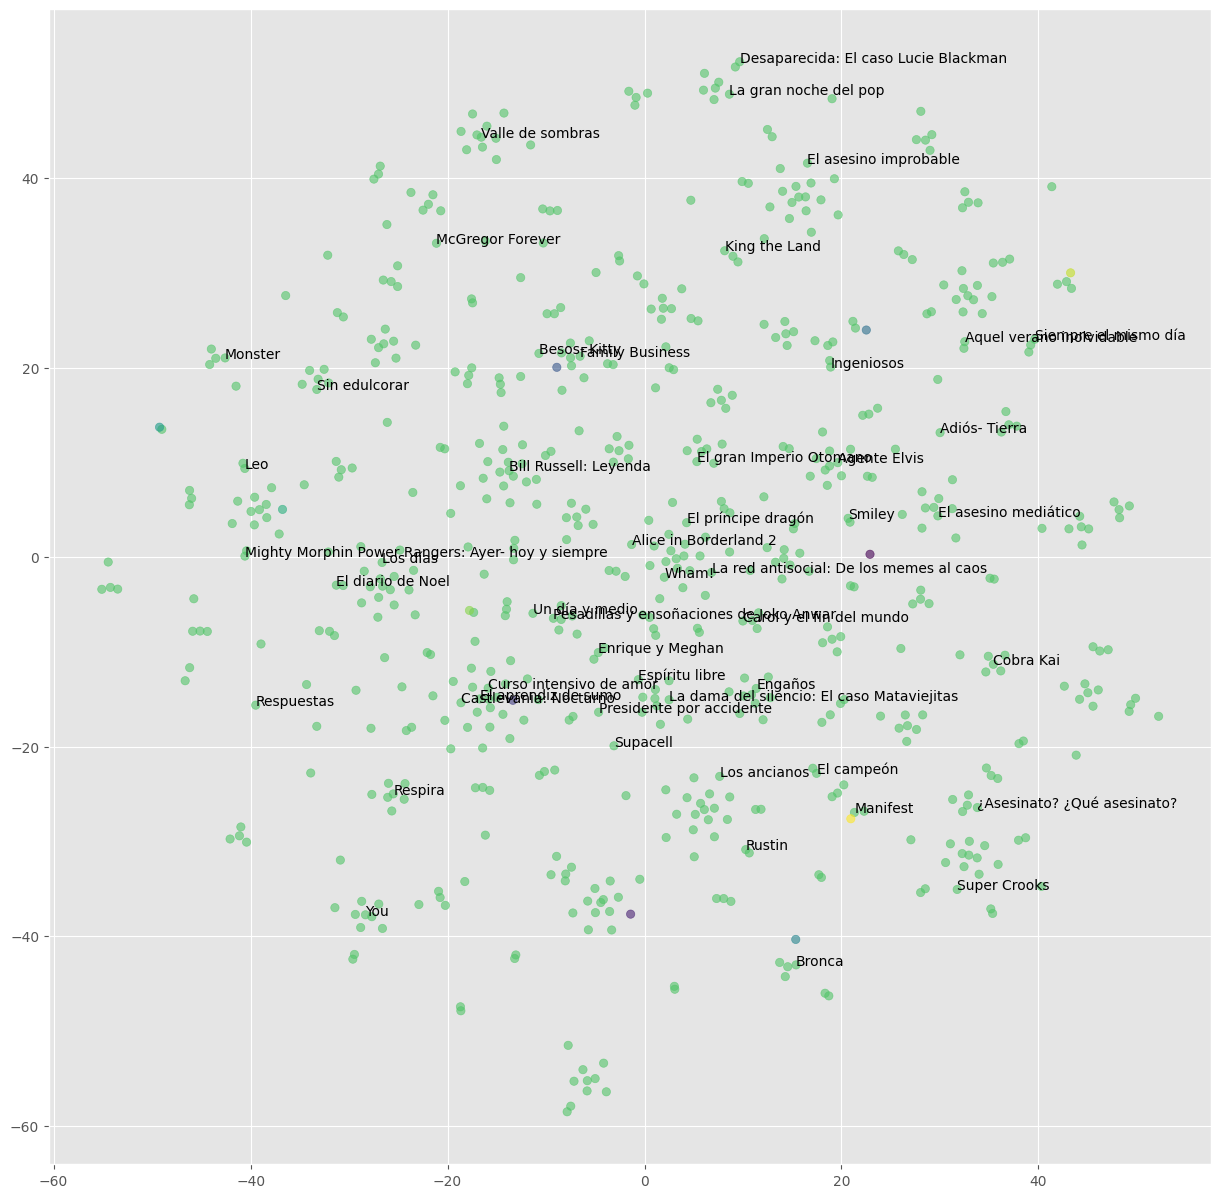

In [86]:
plt.figure(figsize=(15, 15))
# Definimos el número de títulos que se visualizarán
n_docs=50
# Generamos una secuencia de enteros con el tamaño del dataset
idx = np.arange(len(corpus))
# Seleccionamos los índices de los títulos que se mostrarán
valid_idx = np.random.choice(idx, replace=False, size=n_docs)
# Visualizamos las representaciones de t-SNE con el color asociado a la predicción
# de affinity propagation
plt.scatter(T[:, 0], T[:, 1], c=clusters, alpha=0.6)
# Seleccionamos los títulos a visualizar
viz_titles = [titles[i] for i in valid_idx]
# Visualizamos los títulos asociados a cada punto
for label, x, y in zip(viz_titles, T[valid_idx, 0], T[valid_idx, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')

In [87]:
print("Affinity Propagation encontró {} clusters".format(clf.cluster_centers_.shape[0]))

Affinity Propagation encontró 12 clusters


Ahora, veamos algunos ejemplos de películas dentro de cada cluster:

In [89]:
# Generamos una secuencia de enteros correspondiente a los índices de los documentos
idx = np.arange(X_w2v.shape[0])

for clus in range(4):
    # Seleccionamos aleatoriamente los índices de 10 películas dentro del cluster
    example_idxs = np.random.choice(idx[clusters==clus], 10)
    # Seleccionamos los títulos correspondientes
    examples = [titles[i] for i in example_idxs]
    print("Ejemplos aleatorios dentro del cluster {}".format(clus))
    print(examples)

Ejemplos aleatorios dentro del cluster 0
['Un asunto familiar', 'Un asunto familiar', 'Un asunto familiar', 'Un asunto familiar', 'Un asunto familiar', 'Un asunto familiar', 'Un asunto familiar', 'Un asunto familiar', 'Un asunto familiar', 'Un asunto familiar']
Ejemplos aleatorios dentro del cluster 1
['La paradoja del asesino', 'La paradoja del asesino', 'La paradoja del asesino', 'La paradoja del asesino', 'La paradoja del asesino', 'La paradoja del asesino', 'La paradoja del asesino', 'La paradoja del asesino', 'La paradoja del asesino', 'La paradoja del asesino']
Ejemplos aleatorios dentro del cluster 2
['Ni de coña estás invitada a mi bat mitsvá', 'Ni de coña estás invitada a mi bat mitsvá', 'Ni de coña estás invitada a mi bat mitsvá', 'Ni de coña estás invitada a mi bat mitsvá', 'Ni de coña estás invitada a mi bat mitsvá', 'Ni de coña estás invitada a mi bat mitsvá', 'Ni de coña estás invitada a mi bat mitsvá', 'Ni de coña estás invitada a mi bat mitsvá', 'Ni de coña estás invita

Ahora, las nubes de palabras por cluster:

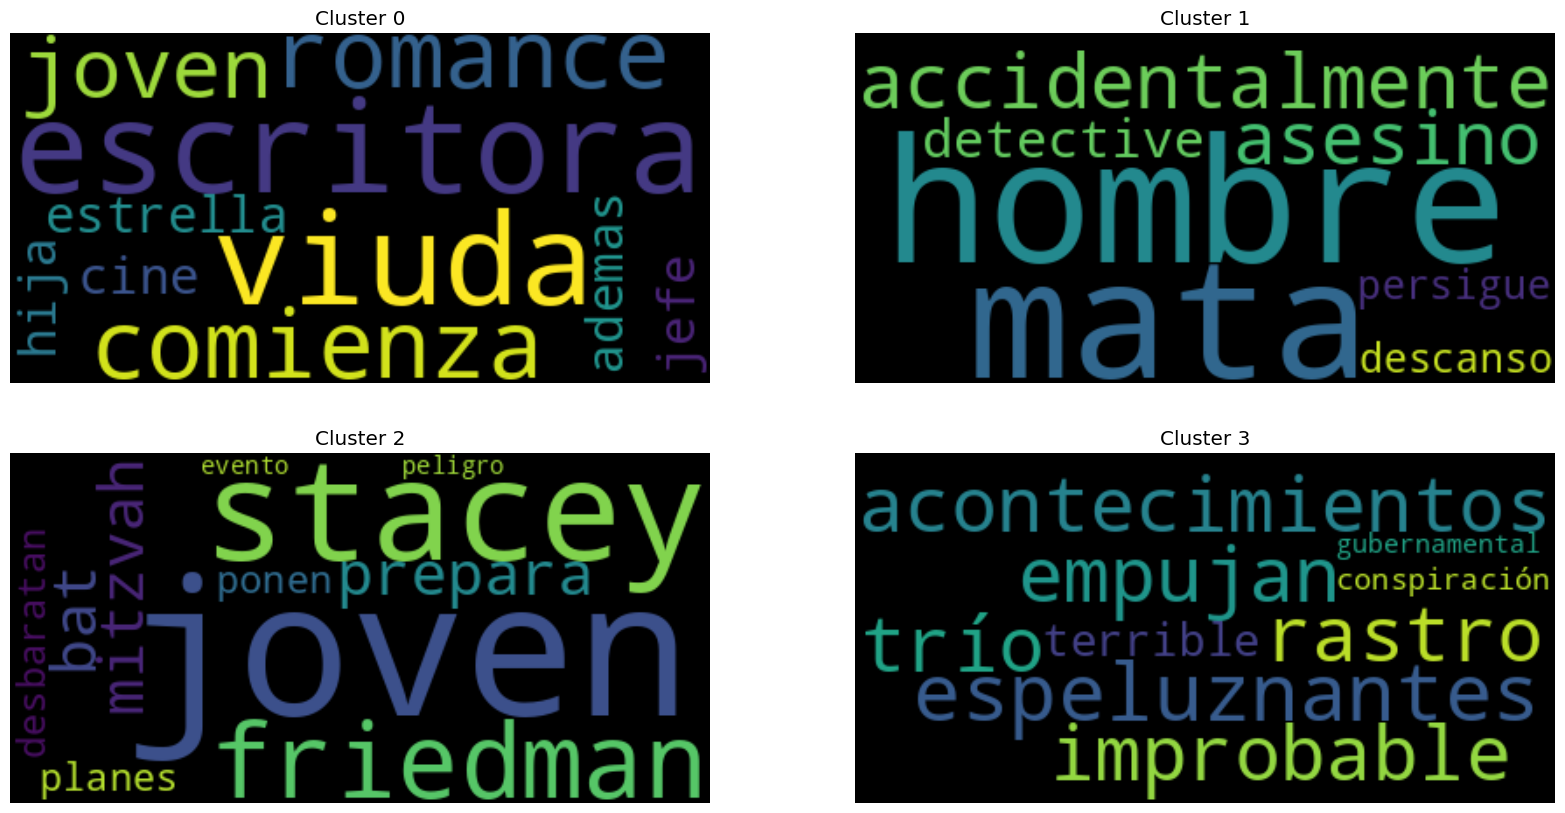

In [90]:
# Generamos una secuencia de enteros correspondiente a los índices de los documentos
idx = np.arange(len(norm_corpus))
plt.figure(figsize=(20,10))
for clus in range(4):
    # Concatenamos las palabras de todos los documentos en cada cluster en un único string
    # (el reduce puede ser reemplazado por " ".join como vimos en ejemplos de clases anteriores)
    all_words = reduce(lambda a, b:a+" "+b, [norm_corpus[i] for i in idx[clusters==clus]])
    # Creamos la nube de palabras
    im = WordCloud(stopwords=stopwords.words("english")).generate(all_words)
    # Visualizamos la nube de palabras
    plt.subplot(221+clus)
    plt.imshow(im, interpolation="bilinear")
    plt.axis("off")
    plt.title("Cluster {}".format(clus))

Finalmente, veamos la distribución de géneros dentro de los primeros clusters:

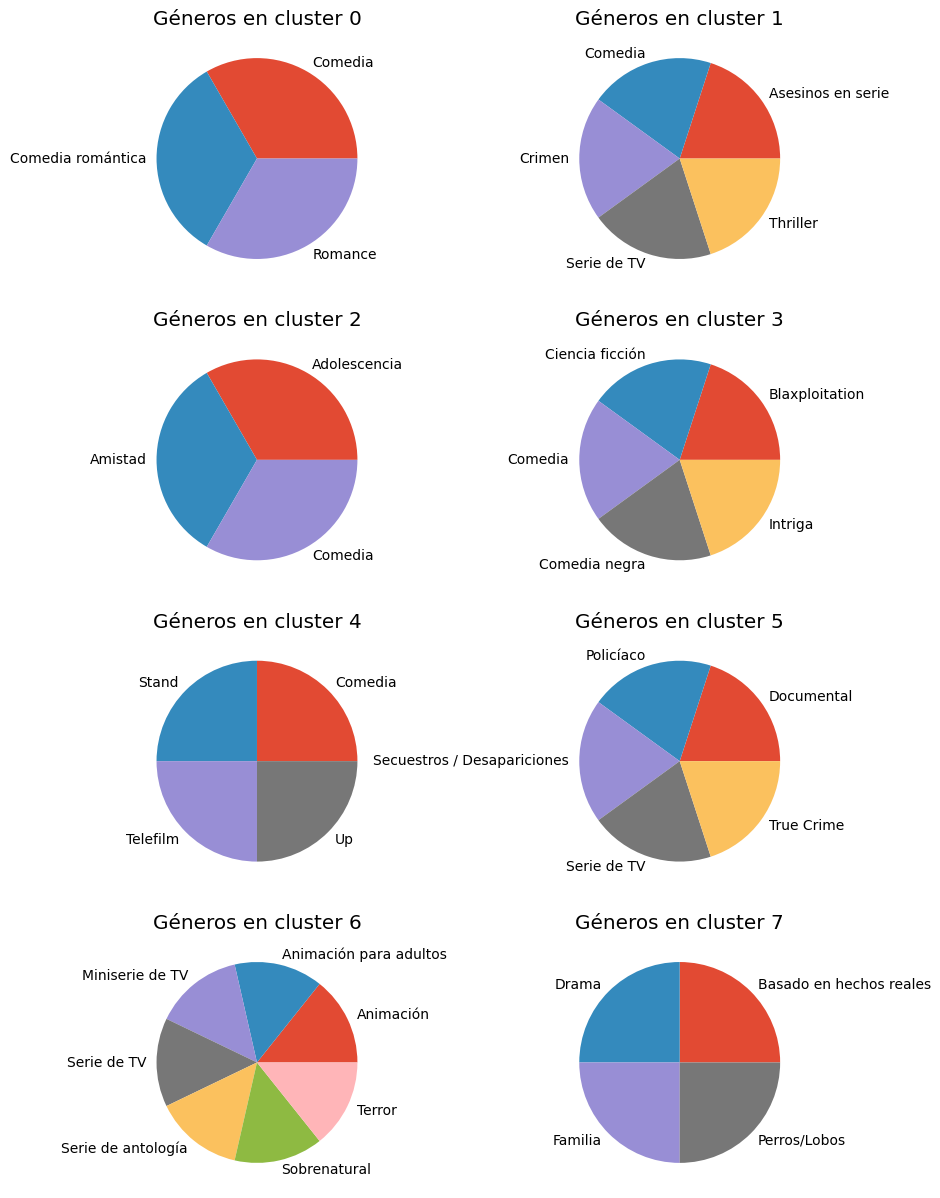

In [91]:
plt.figure(figsize=(10, 15))
for clus in range(8):
    plt.subplot(421+clus)
    # Seleccionamos los índices correspondientes a cada cluster
    example_idxs = idx[clusters==clus]
    # Seleccionamos y concatenamos los géneros de todas las películas en cada cluster
    exam_genres = reduce(lambda a, b:a+b, [genres[i] for i in example_idxs])
    # Obtenemos un conteo de los géneros por cluster
    names, counts = np.unique(exam_genres, return_counts=True)
    # Normalizamos los conteos
    counts = counts/counts.sum()
    # Visualizamos un diagrama de pie
    plt.pie(counts, labels=names)
    plt.title("Géneros en cluster {}".format(clus))

## Hierarchical clustering

Se trata de un algoritmo que al igual que los métodos que hemos visto, agrupa objetos similares en clusters. No obstante, se trata de un método que encuentra relaciones no lineales entre los datos al construir una estructura basada en árboles de jerarquía.

![hierarchical_example](https://46gyn61z4i0t1u1pnq2bbk2e-wpengine.netdna-ssl.com/wp-content/uploads/2018/03/Screen-Shot-2018-03-28-at-11.48.48-am.png)

En general, hay dos tipos de hierarchical clustering: divisivo y aglomerativo.

### Divisive hierarchical clustering

Se trata de una técnica que no es muy usada en la práctica. Utiliza el enfoque opuesto al que utiliza el método aglomerativo. Consiste en asumir que inicialmente todos los puntos pertenecen a un mismo cluster e iterativamente dividirlo en varios grupos por medio de una medida de similitud.

El algoritmo más conocido que utiliza este tipo de clustering es *DIvisive ANAlysis Clustering* (DIANA), el cual estima todas las posibles formas de obtener dos particiones de cada cluster con el fin de determinar la mejor forma de dividir los grupos más heterogéneos.

### Agglomerative hierarchical clustering

El enfoque aglomerativo es el tipo más común de hierarchical clustering. Comienza suponiendo que cada uno de los puntos es un cluster, los cuales se irán fusionando a lo largo de las iteraciones hasta obtener un número deseado de clusters. El método consiste en los siguientes pasos:

1. Calcular una matríz de similitud $\mathbf{S}$.
2. Fusionar los dos clusters más cercanos.
3. Repetir desde el paso 1 hasta obtener un único cluster o un número $K$ de clusters.

Como un cluster puede estar compuesto por varios puntos, existen diversas formas de obtener similitudes:

* MIN: la similitud entre dos clusters es la mínima similitud o distancia entre los puntos de cada cluster.

![min_agglomerative](https://miro.medium.com/max/491/1*mtDL2TynaiwpJlhLdecFYQ.jpeg)

* MAX: la similitud entre dos clusters es la máxima distancia entre los puntos de cada cluster.

![max_agglomerative](https://miro.medium.com/max/491/1*nRYZyjoT1ZRzlWp3oP0_QQ.jpeg)

* Promedio: la similitud entre dos clusters es el promedio entre la similitud de todas las combinaciones de puntos de cada cluster.

![avg_agglomerative](https://miro.medium.com/max/491/1*CMHO0wpT8hCkR_xCQW2ggQ.jpeg)

* Distancia entre centroides: la similitud entre dos clusters es la similitud entre los puntos promedio o centroides de cada cluster.

![centroid_agglomerative](https://miro.medium.com/max/491/1*2AYd0CXANWsM8MLwmrJzYQ.jpeg)

* Ward: la similitud entre dos clusters es la suma de cuadrados media de todas las combinaciones de puntos de cada cluster.

Veamos la aplicación de agglomerative clustering:

In [92]:
# importamos las librerías
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import euclidean_distances

In [93]:
# Calculamos la similitud entre cada punto del dataset
dists = euclidean_distances(X_w2v)

In [94]:
# Construímos el árbol jerárquico
# la función ward retorna una matríz "linkage" con las relaciones de cada rama del árbol.
linkage_matrix = ward(dists)

/usr/local/lib/python3.11/dist-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


El resultado es una matríz $\mathbf{L}$ de tamaño $(N-1)\times 4$. Cada fila $i$ contiene el resultado de cada iteración, y en las columnas se encuentra la siguiente información: $L_{i,0}$ y $L_{i,1}$ contienen los índices de los clusters que se unirán, $L_{i,2}$ contiene la similitud entre los dos clusters y $L_{i,3}$ contiene el número de puntos totales que hay en el cluster formado.

In [95]:
linkage_matrix.shape

(655, 4)

Una de las formas típicas de visualizar el resultado es con un dendograma, el cual, es una representación gráfica en forma de árbol con las relaciones determinadas. Veamos el dendograma:

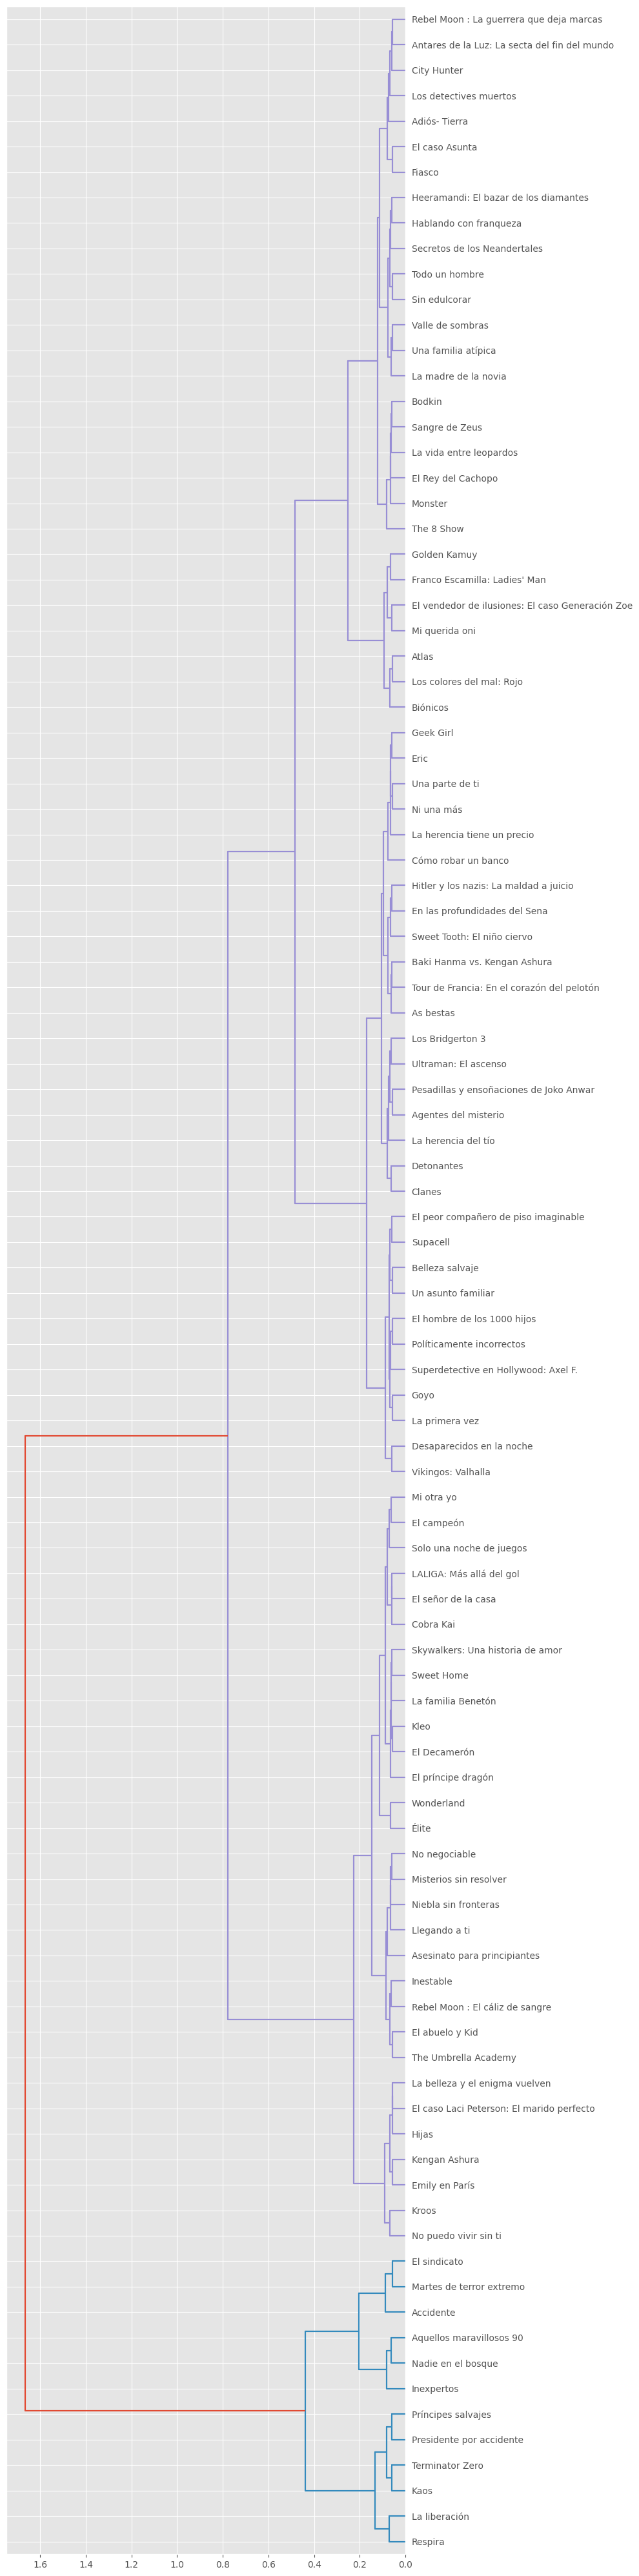

In [96]:
fig, ax = plt.subplots(figsize=(10,40))

# Construímos el dendograma (árbol jerárquico)
R = dendrogram(linkage_matrix, orientation="left", labels=titles,
             truncate_mode='lastp', p=100, no_plot=False)

# Definimos una función para etiquetar cada una de las ramas del árbol.
def llf(x):
    # Asignamos cada uno de los títulos de las películas a cada una de las ramas
    temp = {R["leaves"][i]: titles[i] for i in range(len(R["leaves"]))}
    return "{}".format(temp[x])

# Visualizamos el dendograma
ax = dendrogram(linkage_matrix, truncate_mode='lastp', orientation="left", p=100,
              leaf_label_func=llf, leaf_font_size=10.)
plt.tight_layout()

De igual forma que en K-means, en hierarchical clustering se puede especificar un número $K$ de clusters. Así mismo, cuando no poseemos información sobre el valor de $K$ apropiado para un problema en específico, podemos realizar un análisis exploratorio.

A diferencia de K-means, en este caso no se optimiza directamente una función de pérdida (la cual utilizamos para determinar un número apropiado de clusters). No obstante, existen distintas métricas que pueden ser usadas para medir el desempeño en métodos de clustering. En el caso de Hierarchical Clustering, una de las métricas más usada es la **distancia intercluster**. Consiste en obtener el promedio entre la similitud de todas las posibles combinaciones de puntos de distintos clusters. Veamos un ejemplo de distancias intercluster para un caso de $K=3$.


In [97]:
# Version de Hierarchical clustering que permite seleccionar un número de clusters.
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters=3, linkage="ward")
hc.fit(X_w2v)

AgglomerativeClustering(n_clusters=3)

In [98]:
# Obtenemos el cluster al que pertenece cada punto
preds = hc.labels_
# Calculamos la distancia inter cluster
inter_dists = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        if i > j:
          inter_dists[i,j] = inter_dists[j,i]
        else:
            # Estimamos la distancia promedio entre el cluster i y el cluster j
            inter_dists[i,j] = euclidean_distances(X_w2v[preds==i], X_w2v[preds==j]).mean()

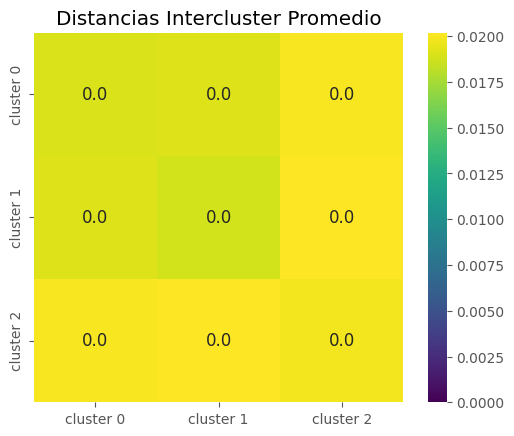

In [99]:
class_names=["cluster {}".format(i) for i in range(3)]
sns.heatmap(inter_dists,square=True,annot=True,cbar=True,
            xticklabels=class_names,yticklabels=class_names,
            annot_kws={"size": 12},fmt=".1f",cmap="viridis",
            vmin=0)
plt.title("Distancias Intercluster Promedio")
plt.show()

Ahora, para determinar un valor de $K$ apropiado, utilizaremos una métrica comúnmente usada en la evaluación de métodos de clustering. El Davies-Bouldin score es una razón entre las distancias intracluster y las distancias intercluster, donde un valor menor representa un mejor resultado de clustering (mayor distancia intercluster y menor distancia intracluster). Veamos un ejemplo:

In [100]:
# En este caso utilizaremos el DB score implementado en sklearn.
from sklearn.metrics import davies_bouldin_score
# definimos el rango de exploración del valor k
ks = np.arange(2, len(X_w2v) + 1, 50)
scores = []
# Iteramos para cada uno de los valores de k
for k in ks:
    # Entrenamos un Hierarchical clustering con cada valor de k
    hc = AgglomerativeClustering(n_clusters=k, linkage="ward")
    hc.fit(X_w2v)
    # Evaluamos el DB score.
    scores.append(davies_bouldin_score(X_w2v,hc.labels_))

Text(0, 0.5, 'Davies-Bouldin')

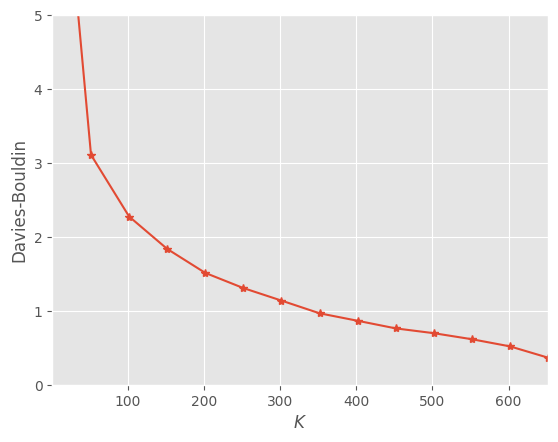

In [101]:
# Visualizamos los resultados
plt.plot(ks,scores,"*-")
plt.xlim([1,ks.max()])
plt.ylim([0,5])
plt.xlabel("$K$")
plt.ylabel("Davies-Bouldin")

## Referencias

* https://medium.com/@MSalnikov/text-clustering-with-k-means-and-tf-idf-f099bcf95183
* https://www.ritchievink.com/blog/2018/05/18/algorithm-breakdown-affinity-propagation/
* https://www.displayr.com/what-is-hierarchical-clustering/
* https://towardsdatascience.com/understanding-the-concept-of-hierarchical-clustering-technique-c6e8243758ec
* https://www.datanovia.com/en/lessons/divisive-hierarchical-clustering/